In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from upsetplot import from_contents, plot

In [2]:
info_job_level_dfs = {}
spatial_job_level_dfs = {}
info_job_level_dfs["gpu_utilization"] = pd.read_csv("job_level_gpu_utilization.csv")

info_job_level_dfs["tensor_active"] = pd.read_csv("job_level_tensor_active.csv")
info_job_level_dfs["fp64_active"] = pd.read_csv("job_level_fp64_active.csv")
info_job_level_dfs["fp32_active"] = pd.read_csv("job_level_fp32_active.csv")
info_job_level_dfs["fp16_active"] = pd.read_csv("job_level_fp16_active.csv")

spatial_job_level_dfs["gpu_utilization"] = pd.read_csv("spatial_job_level_gpu_utilization.csv") 

In [3]:
gputil_all = info_job_level_dfs["gpu_utilization"]
gputil_30 = gputil_all[gputil_all['mean_utilization'] <= 30]
gputil_30_70 = gputil_all[(gputil_all['mean_utilization'] > 30) & (gputil_all['mean_utilization'] < 70)]
gputil_70 = gputil_all[(gputil_all['mean_utilization'] >= 70) & (gputil_all['mean_utilization'] <= 100)] 

In [4]:
submit_lines_df = pd.read_csv("submitline_information.csv")

dl_keywords = [
    'epoch', 'training', 'neural', 'cnn', 'rnn', 'lstm',
    'transformer', 'bert', 'tensorflow', 'pytorch', 'keras', 'deep',
    'machine', 'inference', 'autoencoder',
    'classification', 'detection', 'activation', 'sklearn'
]

gputil_with_submit_lines = pd.merge(gputil_all, submit_lines_df, on='jobid', how='left')

dl_keyword_pattern = '|'.join(dl_keywords)
gputil_with_submit_lines['contains_dl_keyword'] = gputil_with_submit_lines['SubmitLine'].str.contains(dl_keyword_pattern, case=False, regex=True)

dl_job_count = gputil_with_submit_lines['contains_dl_keyword'].sum()
total_jobs_with_submit_lines = len(gputil_with_submit_lines[gputil_with_submit_lines["SubmitLine"].notna()])
nondl_job_count = total_jobs_with_submit_lines - dl_job_count

jobs_with_submit_lines = gputil_with_submit_lines[gputil_with_submit_lines["SubmitLine"].notna()]
dl_jobs_df = jobs_with_submit_lines[jobs_with_submit_lines["contains_dl_keyword"] == True]
nondl_jobs_df = jobs_with_submit_lines[jobs_with_submit_lines["contains_dl_keyword"] == False]

dl_jobids = list(dl_jobs_df["jobid"])
nondl_jobids = list(nondl_jobs_df["jobid"])

gputil_dl_jobs = gputil_all[gputil_all["jobid"].isin(dl_jobids)]
gputil_nondl_jobs = gputil_all[gputil_all["jobid"].isin(nondl_jobids)]


In [5]:
upset_data = from_contents(
    {
        "tensor_active": set(info_job_level_dfs["tensor_active"][info_job_level_dfs["tensor_active"]['jobid'].isin(list(gputil_all["jobid"]))]["jobid"]),
        "fp64_active":  set(info_job_level_dfs["fp64_active"][info_job_level_dfs["fp64_active"]['jobid'].isin(list(gputil_all["jobid"]))]["jobid"]),
        "fp32_active":  set(info_job_level_dfs["fp32_active"][info_job_level_dfs["fp32_active"]['jobid'].isin(list(gputil_all["jobid"]))]["jobid"]),
        "fp16_active":  set(info_job_level_dfs["fp16_active"][info_job_level_dfs["fp16_active"]['jobid'].isin(list(gputil_all["jobid"]))]["jobid"]),
    }
)

In [6]:
gputil_spatial_30 = pd.merge(gputil_30, spatial_job_level_dfs["gpu_utilization"][['jobid', 'spatial_imbalance_gpu_utilization']], on='jobid', how='left').dropna()
gputil_spatial_30_70 = pd.merge(gputil_30_70, spatial_job_level_dfs["gpu_utilization"][['jobid', 'spatial_imbalance_gpu_utilization']], on='jobid', how='left').dropna()
gputil_spatial_70 = pd.merge(gputil_70, spatial_job_level_dfs["gpu_utilization"][['jobid', 'spatial_imbalance_gpu_utilization']], on='jobid', how='left').dropna()

/tmp/ipykernel_372905/767371737.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spatial_upset_dl['category'] = 'ML'
/tmp/ipykernel_372905/767371737.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spatial_upset_nondl['category'] = 'Non-ML'
/tmp/ipykernel_372905/767371737.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

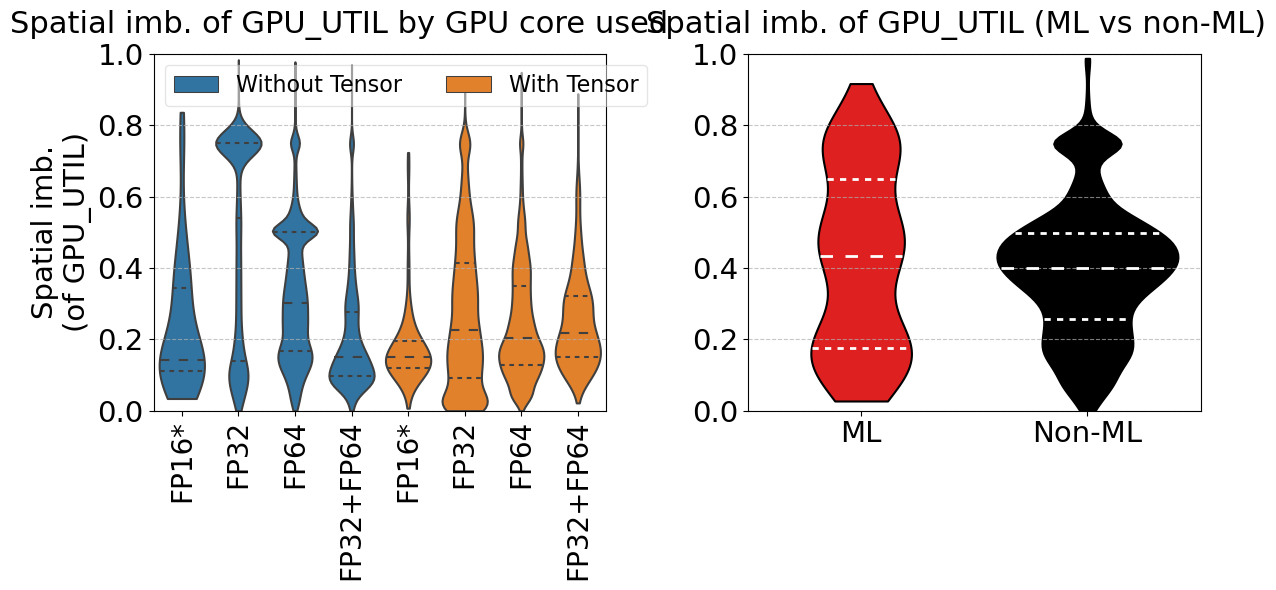

In [7]:
spatial_upset = upset_data.reset_index().dropna()
spatial_upset.rename(columns={'id': 'jobid'}, inplace=True)

spatial_upset = spatial_upset.merge(
    spatial_job_level_dfs["gpu_utilization"][['jobid', 'spatial_imbalance_gpu_utilization']], 
    on='jobid', how='right'
)

spatial_upset_dl = spatial_upset[spatial_upset["jobid"].isin(dl_jobids)]
spatial_upset_nondl = spatial_upset[spatial_upset["jobid"].isin(nondl_jobids)]

# Label them
spatial_upset_dl['category'] = 'ML'
spatial_upset_nondl['category'] = 'Non-ML'

c1 = spatial_upset[
    (spatial_upset["fp16_active"] == True) & 
    (spatial_upset["tensor_active"] == False)
]
c2 = spatial_upset[
    (spatial_upset["fp16_active"] == True) & 
    (spatial_upset["tensor_active"] == True)
]
c3 = spatial_upset[
    (spatial_upset["fp16_active"] == False) &
    (spatial_upset["fp32_active"] == True) & 
    (spatial_upset["fp64_active"] == False) &
    (spatial_upset["tensor_active"] == False)
]
c4 = spatial_upset[
    (spatial_upset["fp16_active"] == False) &
    (spatial_upset["fp32_active"] == True) & 
    (spatial_upset["fp64_active"] == False) &
    (spatial_upset["tensor_active"] == True)
]
c5 = spatial_upset[
    (spatial_upset["fp16_active"] == False) &
    (spatial_upset["fp32_active"] == False) & 
    (spatial_upset["fp64_active"] == True) &
    (spatial_upset["tensor_active"] == False)
]
c6 = spatial_upset[
    (spatial_upset["fp16_active"] == False) &
    (spatial_upset["fp32_active"] == False) &
    (spatial_upset["fp64_active"] == True) &
    (spatial_upset["tensor_active"] == True)
]
c7 = spatial_upset[
    (spatial_upset["fp16_active"] == False) &
    (spatial_upset["fp32_active"] == True) &
    (spatial_upset["fp64_active"] == True) &
    (spatial_upset["tensor_active"] == False)
]
c8 = spatial_upset[
    (spatial_upset["fp16_active"] == False) &
    (spatial_upset["fp32_active"] == True) &
    (spatial_upset["fp64_active"] == True) &
    (spatial_upset["tensor_active"] == True)
]

c1['category'] = 'FP16*'
c2['category'] = 'FP16+Tensor*'
c3['category'] = 'FP32'
c4['category'] = 'FP32+Tensor'
c5['category'] = 'FP64'
c6['category'] = 'FP64+Tensor'
c7['category'] = 'FP32+FP64'
c8['category'] = 'FP32+FP64+Tensor'

combined_df_spatial_1 = pd.concat(
    [c1, c3, c5, c7, c2, c4, c6, c8], 
    ignore_index=True
)

combined_df_spatial_1["group"] = combined_df_spatial_1["category"].apply(
    lambda x: "Without Tensor" if "Tensor" not in x else "With Tensor"
)

combined_df_spatial_2 = pd.concat(
    [spatial_upset_dl, spatial_upset_nondl], 
    ignore_index=True
)

fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=False)

sns.violinplot(
    ax=ax2,
    x="category",
    y="spatial_imbalance_gpu_utilization",   # <-- Key difference
    hue="group",
    data=combined_df_spatial_1,
    common_norm=True,
    dodge=False,
    density_norm="area",
    inner="quartile",
    cut=0,
    palette=sns.color_palette()
)
xtick_labels = ["FP16*", "FP32", "FP64", "FP32+FP64", "FP16*", "FP32", "FP64", "FP32+FP64"]
ax2.set_xticks(range(8), xtick_labels)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90, fontsize=20)

ax2.set_title("Spatial imb. of GPU_UTIL by GPU core used", fontsize=22, pad=15, x=0.41)
ax2.set_ylabel("Spatial imb.\n(of GPU_UTIL)", fontsize=21)
ax2.set_xlabel("")
ax2.tick_params(axis='y', labelsize=21)
ax2.set_ylim(0, 1)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

handles2, labels2 = ax2.get_legend_handles_labels()
ax2.legend([], [], frameon=False)

sns.violinplot(
    ax=ax3,
    x="category",
    y="spatial_imbalance_gpu_utilization", 
    data=combined_df_spatial_2,
    common_norm=True,
    dodge=False,
    density_norm="area",
    inner="quartile",
    cut=0,
    palette={"ML": "red", "Non-ML": "black"}
)
ax3.set_title("Spatial imb. of GPU_UTIL (ML vs non-ML)", fontsize=22, pad=15, x=0.46)
ax3.set_ylabel("")
ax3.set_xlabel("")
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=0, fontsize=21)
ax3.tick_params(axis='y', labelsize=21)
ax3.set_ylim(0, 1)
ax3.grid(axis='y', linestyle='--', alpha=0.7)

for line in ax3.lines:
    line.set_color("white")
    line.set_linewidth(2)

leg = ax2.legend(
    handles=handles2,
    labels=labels2,
    loc="upper left",
    frameon=True,
    fontsize=16,
    ncol=2,
    framealpha=0.5
)

plt.tight_layout()
plt.show()